In [6]:
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

from qtpyt.basis import Basis

# new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/pentacene'
# os.chdir(new_path)

In [7]:
atoms = read("./dft/device/scatt_sorted.xyz")

z_threshold = 8
x_coords = atoms.positions[:, 0]
z_coords = atoms.positions[:, 2]

x_min, x_max = np.min(x_coords), np.max(x_coords)
x_threshold = (x_max + x_min) * 0.5

symbols = atoms.get_chemical_symbols()
total_atoms = len(atoms)

num_spherical_harmonics = {"C": 9, "H": 4}

left_lead_indices = []
right_lead_indices = []
bridge_indices = []

for i, (x, z) in enumerate(zip(x_coords, z_coords)):
    if z < z_threshold:
        if x < x_threshold:
            left_lead_indices.append(i)
        else:
            right_lead_indices.append(i)
    else:
        bridge_indices.append(i)

left_lead_indices = np.array(left_lead_indices)
right_lead_indices = np.array(right_lead_indices)
bridge_indices = np.array(bridge_indices)

print("Total atoms:", total_atoms)
print("Left lead atoms:", len(left_lead_indices))
print("Right lead atoms:", len(right_lead_indices))
print("Bridge atoms:", len(bridge_indices))


total_sph_left_lead = sum(num_spherical_harmonics[symbols[i]] for i in left_lead_indices)
total_sph_bridge = sum(num_spherical_harmonics[symbols[i]] for i in bridge_indices)
total_sph_right_lead = sum(num_spherical_harmonics[symbols[i]] for i in right_lead_indices)

regions = [
    0,
    total_sph_left_lead,
    total_sph_left_lead + total_sph_bridge,
    total_sph_left_lead + total_sph_bridge + total_sph_right_lead
]

print("Number of orbitals in left lead =", regions[1] - regions[0])
print("Number of orbitals in bridge =", regions[2] - regions[1])
print("Number of orbitals in right lead =", regions[3] - regions[2])

# np.save("./output/lowdin/regions.npy", regions)


Total atoms: 114
Left lead atoms: 40
Right lead atoms: 38
Bridge atoms: 36
Number of orbitals in left lead = 290
Number of orbitals in bridge = 254
Number of orbitals in right lead = 272


In [8]:

basis = {'C': 9, 'H': 4}

lead_atoms = read('./dft/leads/leads_sorted.xyz')
leads_basis = Basis.from_dictionary(lead_atoms, basis)

device_atoms = read('./dft/device/scatt_sorted.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis)

nodes = [0, leads_basis.nao, device_basis.nao - leads_basis.nao, device_basis.nao]

# np.save("./output/lowdin/nodes.npy", nodes)

/tmp/ipykernel_871237/430669401.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 256)


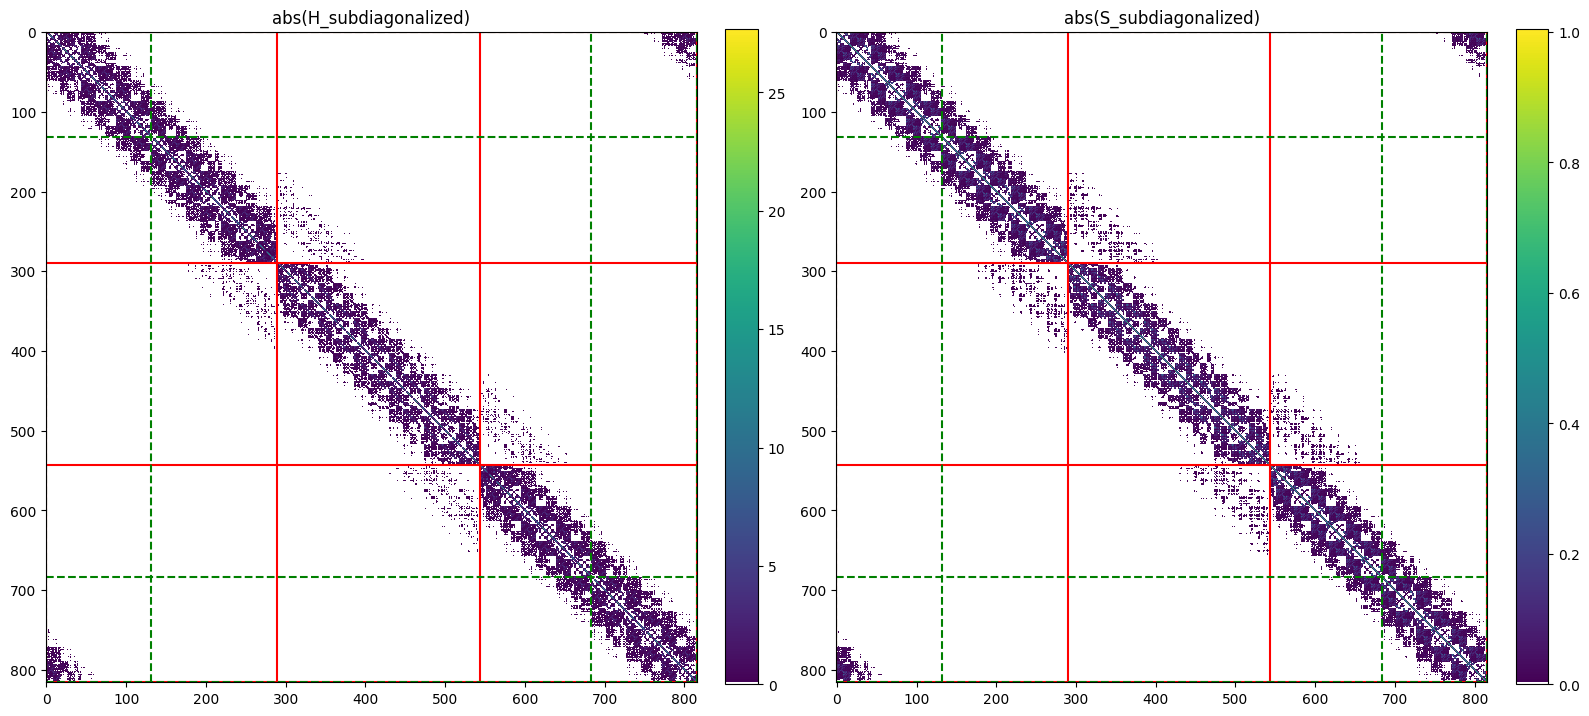

In [9]:
"""
Visualizes the absolute values of the subdiagonalized Hamiltonian matrix with block structure boundaries.

This script performs the following steps:

Loads the region partitioning indices and the subdiagonalized Hamiltonian from the specified data folder.
   - `regions.npy` contains the block boundary indices. Example: [0, 290, 544, 816]
   - `hs_los_lowdin.npy` contains the lowdin-orthogonalized Hamiltonian data.

Plots the absolute values of `H_subdiagonalized` using `imshow` with the custom colormap.

Overlays red horizontal and vertical lines at each region boundary to highlight the block structure of the matrix.


This visualization helps identify the block structure of the Hamiltonian after subdiagonalization, making it easier
to inspect couplings between different subsystems or partitions.

"""

data_folder = "./output/lowdin"
regions = np.load(f"{data_folder}/regions.npy")
H_subdiagonalized, S_subdiagonalized = np.load(f"{data_folder}/hs_los.npy")
H_subdiagonalized = H_subdiagonalized[0]
S_subdiagonalized = S_subdiagonalized[0]
cmap = cm.get_cmap('viridis', 256)
new_colors = cmap(np.linspace(0, 1, 256))
new_colors[0] = [1, 1, 1, 1]
new_cmap = ListedColormap(new_colors)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))


im0 = axes[0].imshow(np.abs(H_subdiagonalized), cmap=new_cmap)
axes[0].set_title("abs(H_subdiagonalized)")
for region in regions:
    axes[0].axhline(region - 0.5, color='red', linewidth=1.5)
    axes[0].axvline(region - 0.5, color='red', linewidth=1.5)

for node in nodes:
    axes[0].axhline(node - 0.5, color='green', linewidth=1.5, linestyle='--')
    axes[0].axvline(node - 0.5, color='green', linewidth=1.5, linestyle='--')

fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)


im1 = axes[1].imshow(np.abs(S_subdiagonalized), cmap=new_cmap)
axes[1].set_title("abs(S_subdiagonalized)")
for region in regions:
    axes[1].axhline(region - 0.5, color='red', linewidth=1.5)
    axes[1].axvline(region - 0.5, color='red', linewidth=1.5)

for node in nodes:
    axes[1].axhline(node - 0.5, color='green', linewidth=1.5, linestyle='--')
    axes[1].axvline(node - 0.5, color='green', linewidth=1.5, linestyle='--')

fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


- The red demarcation lines in the plot above indicate the "left lead", "bridge", "right lead" regions in the subdiagonalized Hamiltonian matrix. This shows how far into the leads regions, the coupling between the leads and the bridge extends. (Look at the non-zero elements in red-boxed region (0,1), (1,0), (1,2) and (2,1).) The non-zero elements in the red-boxed region (0,2) and (2,0) indicate that at this stage, the Hamiltonian still included PBCs.
- The subdiagonalized overlap matrix doesn't look like an identity matrix in the Lowdin orthogonalized case. But this is because the orthogonalization is done only in the active region which is a very small part of the whole matrix. Therefore it will correspond to identity matrix only in the active region (not visible at this scale of the matrix dimensions). The rest of the matrix is not orthogonalized.

### Computing nodes of the tridiagonal matrix

- The nodes of the tridiagonal matrix represent the blocks at which one wants to add the various self-energies. Therefore, if one wants to add the lead self-energies which corresponds to the effect of the infinite leads, one needs to provide appropriate nodes. I believe that the infinite leads self energies need to be added to the part of the leads that don't have any coupling to the bridge. (Is this true, why is this the case?)
- The green dashed lines in the plots below indicate the nodes of the tridiagonal matrix. The topmost and bottommost regions indicate where the lead self-energies need to be added. 